In [1]:
%matplotlib inline
import glob
import pandas as pd
import mne
import matplotlib.pyplot as plt
from io import StringIO
import mne
from mne.io import read_raw_eeglab, read_epochs_eeglab
import numpy as np
from scipy import signal
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm_notebook

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from keras_tqdm import TQDMNotebookCallback
from tensorboard.plugins.hparams import api as hp
from livelossplot.tf_keras import PlotLossesCallback

import autosklearn.regression
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
import multiprocessing
from tpot import TPOTRegressor
from oct2py import octave

from joblib import Parallel, delayed
import multiprocessing
from joblib import wrap_non_picklable_objects
import json
import pickle
import os.path
from mpl_toolkits.mplot3d import axes3d
import tensorflow as tf
from tensorflow.keras import layers
import timeit
from skimage.transform import resize

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
Using TensorFlow backend.
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/pyparsing.py:2927: FutureWarning: Possible set intersection at position 3
  self.re = re.compile( self.reString )


In [2]:
eeglab_path = '/home/raquib/Documents/MATLAB/eeglab2019_0/functions/'
octave.addpath(eeglab_path + 'guifunc');
octave.addpath(eeglab_path + 'popfunc');
octave.addpath(eeglab_path + 'adminfunc');
octave.addpath(eeglab_path + 'sigprocfunc');
octave.addpath(eeglab_path + 'miscfunc');

In [3]:
experiment = 'data/original/*/*'
meps = sorted(glob.glob(experiment + '/mep/*/*.txt'))
mep_present = len(meps) > 0
eegs = sorted(glob.glob(experiment + '/eeg/*/clean-prestimulus.set'))
eeg_present = len(eegs) > 0
cmaps = sorted(glob.glob(experiment + '/cmap/*.xlsx'))
cmap_present = len(cmaps) > 0
all_present = mep_present and eeg_present and cmap_present
print(all_present)

True


In [4]:
print('EEG count: ' + str(len(eegs)))
print('MEP count: ' + str(len(meps)))
print('CMAP count: ' + str(len(cmaps)))

EEG count: 44
MEP count: 77
CMAP count: 22


In [5]:
eegs

['data/original/sub03/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
 'data/original/sub03/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
 'data/original/sub03/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
 'data/original/sub03/exp02/eeg/SP 110RMT r1/clean-prestimulus.set',
 'data/original/sub03/exp02/eeg/SP 110RMT r2/clean-prestimulus.set',
 'data/original/sub03/exp03/eeg/SP 110RMT r1/clean-prestimulus.set',
 'data/original/sub03/exp03/eeg/SP 110RMT r2/clean-prestimulus.set',
 'data/original/sub03/exp03/eeg/SP 110RMT r3/clean-prestimulus.set',
 'data/original/sub04/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
 'data/original/sub04/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
 'data/original/sub04/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
 'data/original/sub05/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
 'data/original/sub05/exp02/eeg/SP 120RMT r2/clean-prestimulus.set',
 'data/original/sub06/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
 'data/original/sub06/exp01/eeg/SP

In [6]:
eegs = [
    'data/original/sub03/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub03/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub03/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
#     'data/original/sub03/exp02/eeg/SP 110RMT r1/clean-prestimulus.set', NO CMAP
#     'data/original/sub03/exp02/eeg/SP 110RMT r2/clean-prestimulus.set', NO CMAP
#     'data/original/sub03/exp03/eeg/SP 110RMT r1/clean-prestimulus.set', NO CMAP
    'data/original/sub03/exp03/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub03/exp03/eeg/SP 110RMT r3/clean-prestimulus.set',
#     'data/original/sub04/exp01/eeg/SP 110RMT r1/clean-prestimulus.set', NO CMAP
#     'data/original/sub04/exp01/eeg/SP 110RMT r2/clean-prestimulus.set', NO CMAP
#     'data/original/sub04/exp01/eeg/SP 110RMT r3/clean-prestimulus.set', NO CMAP
#     'data/original/sub05/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub06/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub06/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub06/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub06/exp02/eeg/SP 110RMT/clean-prestimulus.set',
    'data/original/sub07/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub07/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub07/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub08/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub08/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub08/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub08/exp02/eeg/SP 110RMT/clean-prestimulus.set',
    'data/original/sub08/exp03/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub08/exp03/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub08/exp03/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub12/exp02/eeg/SP 110RMT/clean-prestimulus.set',
#     'data/original/sub13/exp01/eeg/SP 110RMT/clean-prestimulus.set', LEFT HANDED
    'data/original/sub14/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub15/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub15/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub15/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub16/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub16/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub16/exp01/eeg/SP 110RMT r3/clean-prestimulus.set'
]

# Read and process EEG

In [7]:
def read_eeg(path):
    eeg = octave.pop_loadset(path)
    new_trial_list = []
    for i in range(eeg.data.shape[2]):
        trial = eeg.data[:, :, i]
        time = np.linspace(-1000, -20, num=trial.shape[1])
        trial = pd.DataFrame(np.transpose(trial), columns=eeg.chanlocs.labels[0])
        trial['time'] = time
        new_trial_list.append(trial)
    return new_trial_list

def crop_trials(trial_list, duration_millis=500, sampling_rate=2048):
    new_trial_list = []
    for trial in trial_list:
        samples_to_pick = duration_millis * sampling_rate / 1000
        new_trial_list.append(trial.tail(int(samples_to_pick)))
    return new_trial_list, samples_to_pick

# Calculate EEG area.
def calculate_eeg_area(epoch_df, sf=2048):
    y = epoch_df.drop('time', axis=1).mean(axis=1)
    b2, a2 = signal.butter(4, 200/(sf/2), btype='lowpass')
    envelope = signal.filtfilt(b2, a2, np.abs(y))
    area = np.trapz(envelope, epoch_df['time'].values)
    return area

# Calculate EEG frequency.
def calculate_eeg_frequency(channel):
    sf = 2048
    win = 4 * sf
    freqs, psd = signal.welch(channel, sf, nperseg=win)
    return freqs, psd

def calculate_eeg_max_amplitude(epoch_df):
    avg = epoch_df.mean(axis=1)
    return np.max(avg.values)

def band_max(freq, psd, interval):
    indices = []
    for el in freq:
        indices.append(el in interval)
    freq = freq[indices]
    psd = psd[indices]
    if (len(psd) == 0):
        return 0, 0
    i = np.argmax(np.abs(psd))
    return freq[i], psd[i]

def filter_electrodes(trial, which='all'):
    time_column = trial['time']
    if which == 'ltm1':
        channel_names = ['FC5','FC1','C3','CP5','CP1','FC3','C5','C1','CP3']
    elif which == 'rtm1':
        channel_names = ['FC6','FC2','C4','CP6','CP2','FC4','C6','C2','CP4']
    elif which == 'central':
        channel_names = ['Fz','FCz','Cz','F1','FC1','C1','C2','FC2','F2']
    else:
        channel_names = ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'O2', 'EOG', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC3', 'FCz', 'FC4', 'C5', 'C1', 'C2', 'C6', 'CP3', 'CP4', 'P5', 'P1', 'P2', 'P6', 'PO5', 'PO3', 'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Oz']
    trial = trial[channel_names]
    trial['time'] = time_column
    return trial

def read_wavelets(sub, exp, run, epoch_num):
    path = 'wavelets/' + sub + '-' + exp + '-' + run + '-' + str(epoch_num)
    with open(path + '-central.pickle', 'rb') as f:
        central = pickle.load(f)
    with open(path + '-ltm1.pickle', 'rb') as f:
        ltm1 = pickle.load(f)
    with open(path + '-rtm1.pickle', 'rb') as f:
        rtm1 = pickle.load(f)
    with open(path + '-all.pickle', 'rb') as f:
        all_channels = pickle.load(f)
    return all_channels, ltm1, rtm1, central

def wavelet_band_max(df, interval):
    indices = []
    for el in (df.index * 1000):
        indices.append(el in interval)
    df = df[indices]
    if (df.shape[0] == 0):
        return 0, 0, 0, 0
    return df.mean(axis=1).max(), df.mean(axis=1).argmax() * 1000, df.mean(axis=0).max(), df.mean(axis=0).argmax()

# Read features file

In [8]:
features_filename = '55-features-v1.xlsx'

In [9]:
df = pd.read_excel(features_filename, index_col=0)

p1 = np.percentile(df['mep_category_cmap'], 50)
cat = np.ones(len(df['mep_category_cmap'])) * (df['mep_category_cmap'] > p1)
df['mep_category_cmap_across_subjects'] = cat

# Prepare wavelet dataframe

In [10]:
def normalize_image(image, mx=1, mn=0):
    wt_min = image.min().min()
    std = (image.values - wt_min) / (image.max().max() - wt_min)
    image.loc[:, :] = std * (mx - mn) + mn
    return image

In [11]:
df_wt = []
df_mean = np.zeros((37,983))

In [12]:
start_time_sec = -500
end_time_sec = -20
        
for idx, epoch in tqdm_notebook(df.iterrows(), total=df.shape[0]):
    wt_all, wt_ltm1, wt_rtm1, wt_central = read_wavelets(epoch['sub'], epoch['exp'], epoch['run'], epoch['epoch'])

    # Take 6-50Hz frequencies.
#     wt_all = wt_all[(wt_all.index * 1000 > 6) * (wt_all.index * 1000 < 50)]
    wt_ltm1 = wt_ltm1[(wt_ltm1.index * 1000 > 2) * (wt_ltm1.index * 1000 < 50)]
#     wt_rtm1 = wt_rtm1[(wt_rtm1.index * 1000 > 6) * (wt_rtm1.index * 1000 < 50)]
#     wt_central = wt_central[(wt_central.index * 1000 > 6) * (wt_central.index * 1000 < 50)]

    # Take only last -100ms to -20ms.
#     wt_all = wt_all.loc[:, wt_all.columns.isin(wt_all.columns[(wt_all.columns >= (start_time_sec/1000)) * (wt_all.columns <= (end_time_sec/1000))])]
    wt_ltm1 = wt_ltm1.loc[:, wt_ltm1.columns.isin(wt_ltm1.columns[(wt_ltm1.columns >= (start_time_sec/1000)) * (wt_ltm1.columns <= (end_time_sec/1000))])]
#     wt_rtm1 = wt_rtm1.loc[:, wt_rtm1.columns.isin(wt_rtm1.columns[(wt_rtm1.columns >= (start_time_sec/1000)) * (wt_rtm1.columns <= (end_time_sec/1000))])]
#     wt_central = wt_central.loc[:, wt_central.columns.isin(wt_central.columns[(wt_central.columns >= (start_time_sec/1000)) * (wt_central.columns <= (end_time_sec/1000))])]
    
    norm = normalize_image(wt_ltm1)
    df_wt.append(norm)
    df_mean = np.add(df_mean, norm.values)

Text(0.5, 1, 'Mean of all')

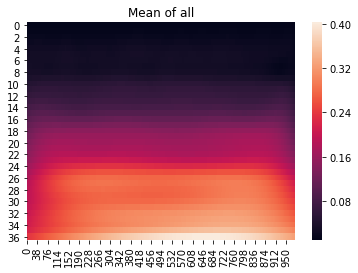

In [13]:
df_mean = df_mean / df.shape[0]
plt.figure()
sns.heatmap(df_mean)
plt.title('Mean of all')

Text(0.5, 1, '5th epoch wavelet')

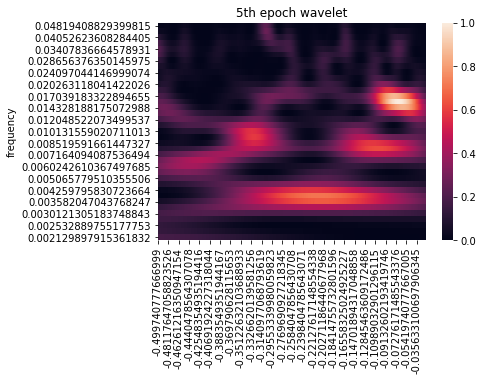

In [14]:
plt.figure()
sns.heatmap(df_wt[55])
plt.title('5th epoch wavelet')

In [15]:
df_wt2 = []
for wt in tqdm_notebook(df_wt):
    df_wt2.append(normalize_image(np.add(wt, -df_mean)))
df_wt = df_wt2

Text(0.5, 1, '5th epoch wavelet after subtraction')

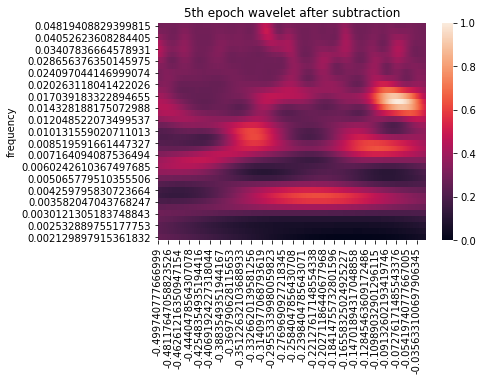

In [16]:
plt.figure()
sns.heatmap(df_wt[55])
plt.title('5th epoch wavelet after subtraction')

In [17]:
df_wt[5].shape

(37, 983)

# Keras

In [18]:
x = []
for wt in tqdm_notebook(df_wt):
    img = np.array(wt.values)
    img = resize(img, (160, 160))
    img = np.stack([img]*3, axis=-1)
    x.append(img)
x = np.array(x)
y = cat
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=12)
x_train.shape

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(1050, 160, 160, 3)

In [19]:
# def parse_fn(img, label):
#     img = tf.cast(img, tf.float32)
#     return img, label

In [20]:
BATCH_SIZE = 50
LOG_DIR = 'logs/tensorboard/76-wavelet-hyper-v2/'
EPOCHS = 50

In [21]:
# train_data = tf.data.Dataset.from_tensor_slices((tf.constant(x_train), tf.constant(y_train)))
# val_data = tf.data.Dataset.from_tensor_slices((tf.constant(x_test), tf.constant(y_test)))
# train_data = (train_data.map(parse_fn).shuffle(buffer_size=10000).batch(BATCH_SIZE))
# val_data = (val_data.map(parse_fn).shuffle(buffer_size=10000).batch(BATCH_SIZE))

In [22]:
base_model = tf.keras.applications.ResNet50(input_shape=(160, 160, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = tf.keras.Sequential([
    base_model, 
    tf.keras.layers.GlobalAveragePooling2D(), 
    tf.keras.layers.Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 5, 5, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


In [23]:
cb = [
    tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR)
]
history1 = model.fit(x_train, y_train, epochs=EPOCHS, validation_data=(x_test, y_test), callbacks=cb, verbose=0)

W0826 14:53:35.861570 140553845098304 deprecation.py:323] From /home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0826 14:53:39.314017 140553845098304 callbacks.py:241] Method (on_train_batch_end) is slow compared to the batch update (0.169427). Check your callbacks.


In [34]:
def plot_history(history):
    plt.figure(figsize=(10,5))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left') 
    plt.show()
    
    plt.figure(figsize=(10,5))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

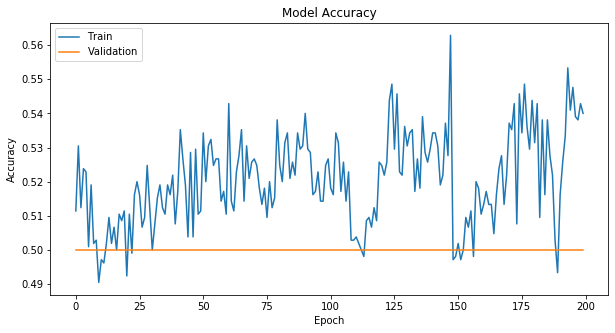

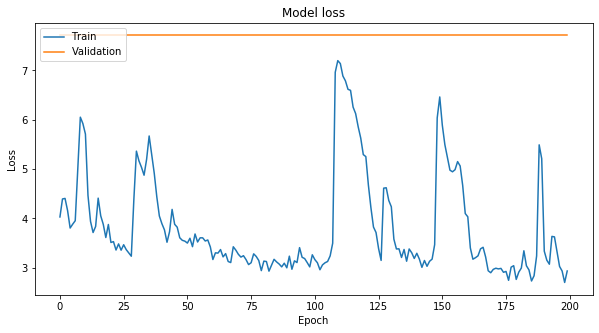

In [35]:
plot_history(history1)

# Fine tune

In [24]:
base_model.trainable = True

for layer in base_model.layers[:100]:
    layer.trainable =  False

model.compile(loss='binary_crossentropy', optimizer = tf.keras.optimizers.Adam(lr=0.00001), metrics=['accuracy'])
history2 = model.fit(x_train, y_train, epochs=EPOCHS+50, initial_epoch=EPOCHS, validation_data=(x_test, y_test), callbacks=cb, verbose=0)

KeyboardInterrupt: 

In [36]:
plot_history(history2)

NameError: name 'history2' is not defined